## Using a Fourier Transform to Remove Crowd Noise

#### _Import Statements_

In [276]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.io.wavfile import read, write
from matplotlib import pyplot as plt

#### _Load the Crowd Noise_

We can load in the crowd noise as an array data structure:

In [287]:
crowd_wav = read('data/cheers.wav')
actual_wav = read('data/source.wav')

The noise then has two components, the number of data points (index 0) and the amplitudes over time (index 1):

In [42]:
print(crowd_wav[0])

44100


In [289]:
print(actual_wav[1])

[[-83886080 -83886080]
 [-89391104 -89391104]
 [-76283904 -76283904]
 ...
 [   -28416     44544]
 [   -24832     25600]
 [   -14592     11008]]


We can plot the waveform to see what it looks like:

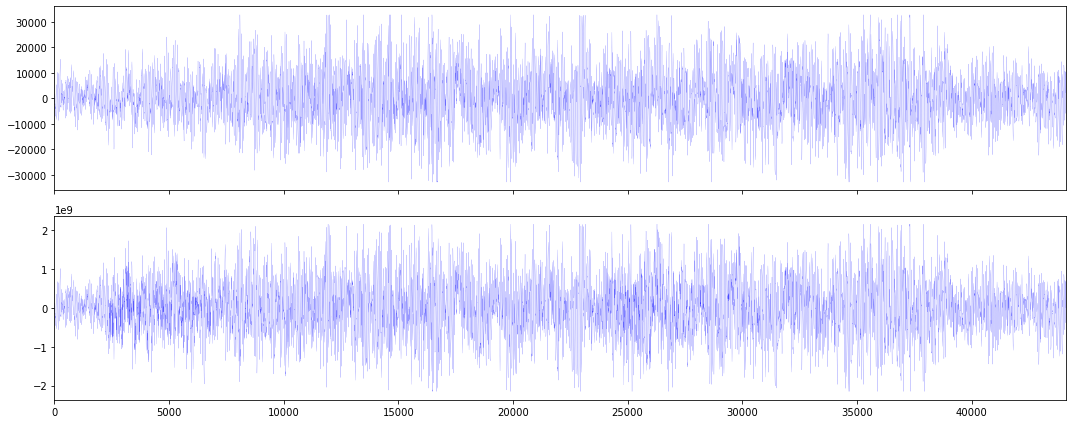

In [298]:
fig, ax = plt.subplots(2, 1, figsize = (15, 6), sharex = True)

ax[0].plot(crowd_wav[1], lw = 0.1, c = 'blue')
ax[1].plot(actual_wav[1][:, 0], lw = 0.1, c = 'blue')

ax[0].set_xlim(0, crowd_wav[1].shape[0])

fig.tight_layout()

To find out which frequencies are most occuring, we can take the fast Fourier transform to get the power value spectrum:

In [301]:
crowd_wav_fft = fft(crowd_wav[1]).real
source_wav_fft = fft(actual_wav[1][:, 0]).real

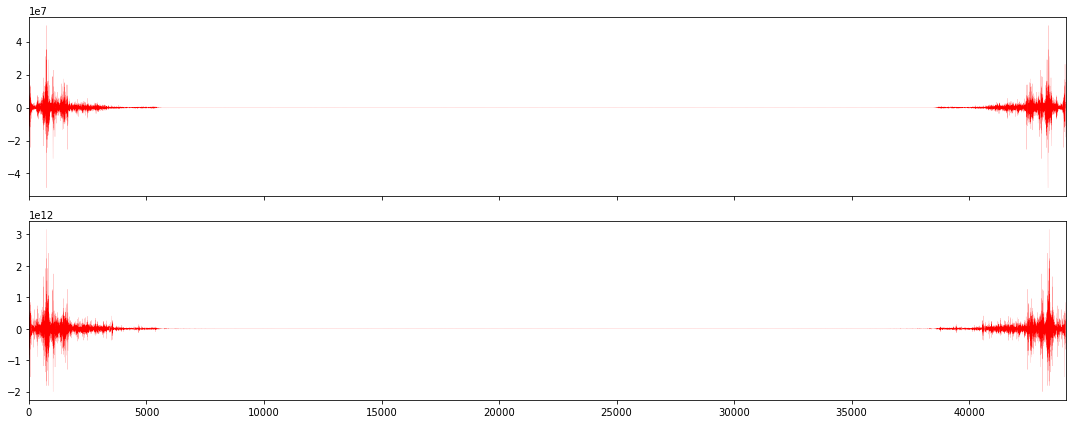

In [303]:
fig, ax = plt.subplots(2, 1, figsize = (15, 6), sharex = True)

ax[0].plot(crowd_wav_fft, lw = 0.1, c = 'red')
ax[1].plot(source_wav_fft, lw = 0.1, c = 'red')

ax[1].set_xlim(0, crowd_wav_fft.shape[0])

fig.tight_layout()

So, knowing that there's a high frequency near the end, we can find the mean of the non-zero elements:

In [304]:
temp_wav_fft = crowd_wav_fft[crowd_wav_fft.shape[0]//2:]

In [305]:
nonzero_fft = temp_wav_fft[temp_wav_fft > 1000]

In [306]:
crowd_fft_mean = np.mean(nonzero_fft)
crowd_fft_std = np.std(nonzero_fft)

In [307]:
arg_mean = np.argsort(crowd_fft_mean - crowd_wav_fft)
arg_mean = arg_mean[arg_mean > crowd_wav_fft.shape[0]//2][0]

In [308]:
print(crowd_fft_mean, crowd_fft_std, arg_mean)

688399.3415327515 2149567.496535296 43359


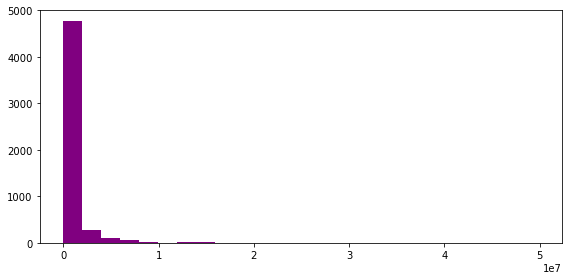

In [309]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4))

ax.hist(nonzero_fft, 25, color = 'purple')

fig.tight_layout()

In [310]:
def threshold_fft(wave, threshold):
    
    '''
        wave -> the waveform to be thresholded in numpy array format
        threshold -> the range by which to reduce data, in tuple format
    '''
    
    lower_thresh = int(threshold[0])
    upper_thresh = int(threshold[1])
    
    wave = wave.copy()
    
    n = wave.shape[0]
    if n < upper_thresh:
        upper_thresh = n
    
    wave[lower_thresh:upper_thresh] = 0
    wave[(n - upper_thresh):(n - lower_thresh)] = 0
    
    return wave

In [311]:
new_wave = threshold_fft(crowd_wav_fft, (0, 5000))

In [314]:
def locate_indices(data, mean, perc):
    
    '''
        data -> to locate the position in the data
        mean -> the average of the selected data
        perc -> the percentage to deviate from the mean by
    '''
    
    lower = mean - perc*mean
    upper = mean + perc*mean
    
    return (int(lower), int(upper))

In [334]:
crowd_wav_fft.shape

(44100,)

In [335]:
source_wav_fft.shape

(44144,)

In [328]:
lwr, upr = locate_indices(crowd_wav_fft, arg_mean, 0.005)

In [329]:
better_fft = threshold_fft(source_wav_fft.copy(), (lwr, upr))

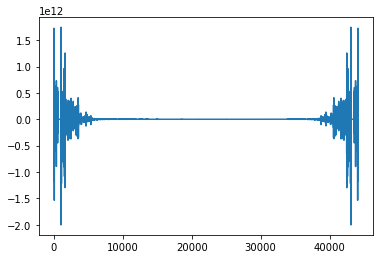

In [330]:
plt.plot(better_fft)

In [331]:
wav_ifft = ifft(better_fft).real

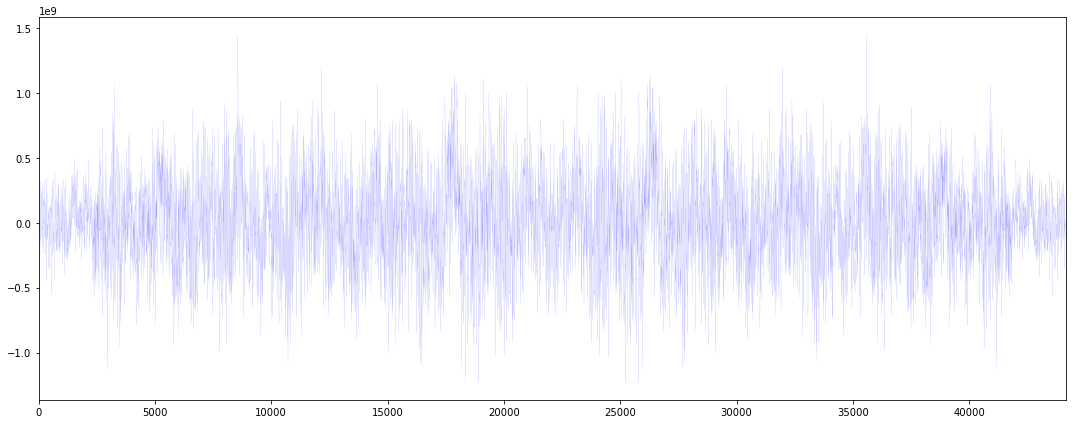

In [332]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))

ax.plot(wav_ifft, lw = 0.05, c = 'blue')

ax.set_xlim(0, wav_ifft.shape[0])

fig.tight_layout()

In [333]:
write("example4.wav", crowd_wav[0], wav_ifft.astype(np.int16))